<a href="https://colab.research.google.com/github/ioskn/mldl_htwg/blob/master/boosting/Least_Square_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Least Square Boosting

Notes
* We first implement the least square boosting by "hand" to show that we 100 percent understand the algorithm.
To make this code easy readable, we only consider the training data. After showing that our implementation is correct (same as scikit-learn), we also use test data.
* Then we demonstrate that this methods is the same then the scikit-learn implementation. 

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('default')

In [49]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn import tree

### Creating the data

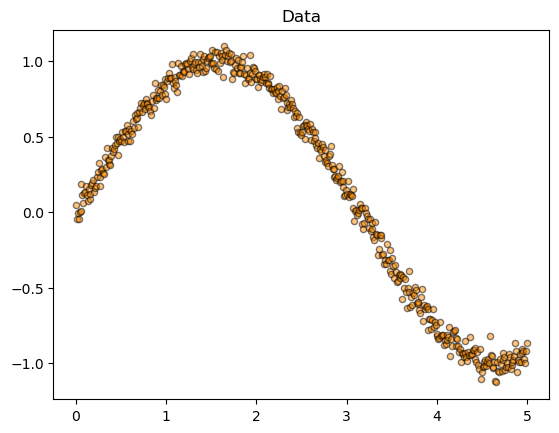

In [50]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
num_data = 500
X = np.linspace(0,5,num_data).reshape(num_data,1)
y = np.sin(X).ravel() + np.random.normal(0,0.05,num_data)

def plot_current_f(X,y,ypreds, M=-1):
    plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data", alpha=0.5)
    if (M > 0):
        plt.plot(X, ypreds, color="cornflowerblue",label="max_depth=1", linewidth=2)
        plt.title('Number of trees : {}'.format(M))
    else:
        plt.title('Data')

plot_current_f(X,y,y)

#### M = 1 The first stump

Here we fit a simple stump (high bias) to the data. 

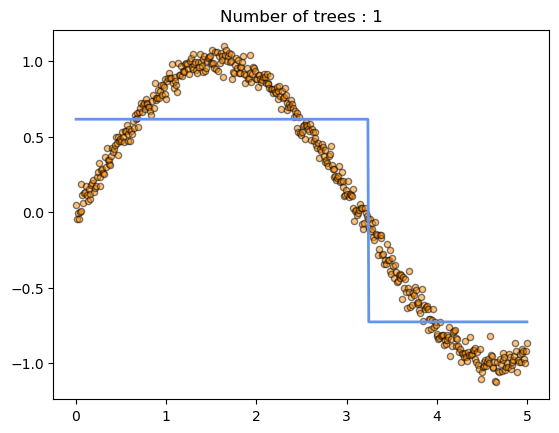

In [51]:
# Fit regression model
tree1 = DecisionTreeRegressor(max_depth=1)
tree1.fit(X, y)
ypreds = tree1.predict(X)
plot_current_f(X,y,ypreds, 1)

#### M = 1...3 The first 3 Stages

Here we fit a simple stump (high bias) to the data. Then, we fit a "delta" model to the residuals.

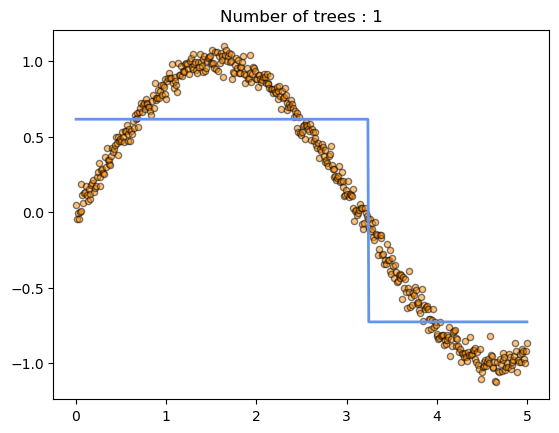

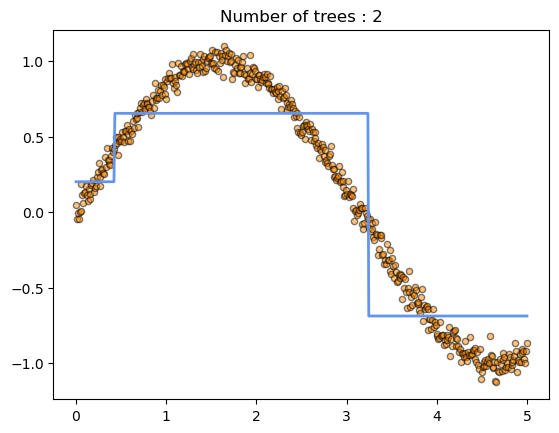

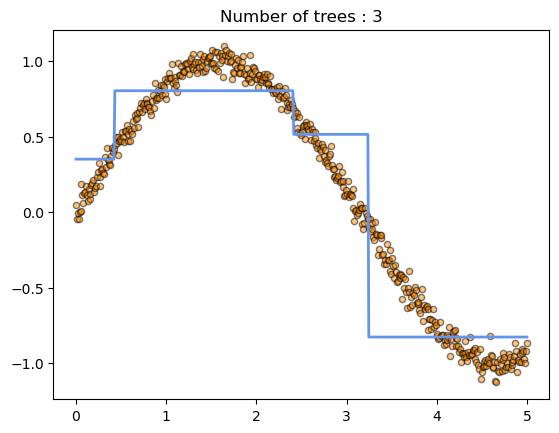

In [52]:
fx = np.zeros(num_data) #See Step 1 in Algo 10.2
for m in range(3):
    tree = DecisionTreeRegressor(max_depth=1)
    res = y - fx #Calculation of the rediduals
    tree.fit(X, res) #Fitting to the residuals (Steps 2a)
    fx = fx + tree.predict(X) #The new predictions (Step 2b)
    plot_current_f(X,y,fx,m+1)
    plt.show()

# Comparison with scikit-learn implementation

In [53]:
LR = 1 #Change to lower values (see later)
n_estimators = 20 #Number of trees

In [54]:
fx = np.zeros(num_data) #See Step 1 in Algo 10.2
for m in range(n_estimators):
    tree = DecisionTreeRegressor(max_depth=1)
    res = y - fx #Calculation of the rediduals
    tree.fit(X, res) #Fitting to the residuals (Steps 2a)
    fx = fx + LR * tree.predict(X) #The new predictions (Step 2b) with LR

Difference between our implementation an sklearn : 9.951665208637725e-33


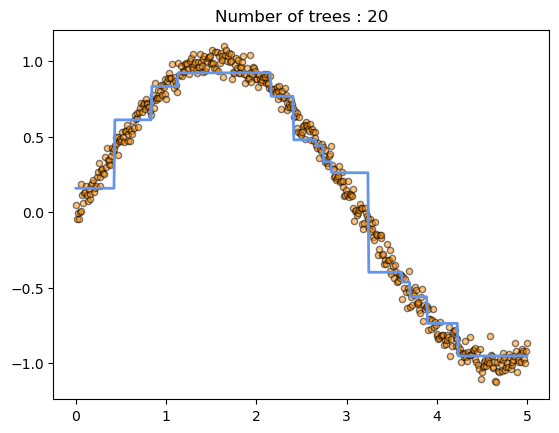

In [55]:
from sklearn.ensemble import GradientBoostingRegressor
est = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=LR,
                                max_depth=1, random_state=0, loss='squared_error')
est.fit(X, y)
ypred = est.predict(X) 
plot_current_f(X,y,ypred, n_estimators)
print("Difference between our implementation an sklearn :", np.mean((fx - ypred)**2))

**Play Around** Change the number of estimators to 1000 and see what happens 

# Overfitting

We now want to invesitate the issue of overfitting. For this purpose, we create a limited amount of training data. A little technicallity: We switch to the sklearn implementation, since it allows for test-data points.

In [56]:
def create_data():
    X = np.sort(5 * rng.rand(80, 1), axis=0)
    y = np.sin(X).ravel() + np.random.normal(0,0.25,80)
    return X,y

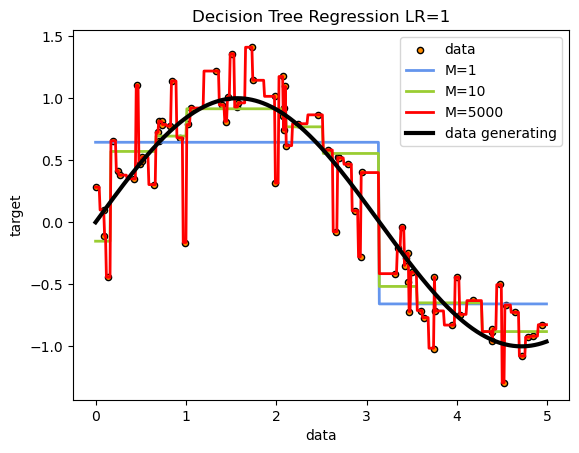

In [57]:
LR = 1
max_tree = 5000
X,y = create_data()
# Fit regression model
regr_1 = GradientBoostingRegressor(n_estimators=1, learning_rate=LR,max_depth=1, random_state=0, loss='squared_error')
regr_2 = GradientBoostingRegressor(n_estimators=10, learning_rate=LR,max_depth=1, random_state=0, loss='squared_error')
regr_3 = GradientBoostingRegressor(n_estimators=max_tree, learning_rate=LR,max_depth=1, random_state=0, loss='squared_error')
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",label="M=1", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="M=10", linewidth=2)
plt.plot(X_test, y_3, color="red", label="M={}".format(max_tree), linewidth=2)
plt.plot(X_test[:,0], np.sin(X_test[:,0]), linewidth=3, color='black',label="data generating")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression LR={}".format(LR))
plt.legend()
plt.show()

For M=5000, we see a clear sign of overfitting. Let's plot the MSE to the DGP vs. M.

Minimum of the test error at M=39


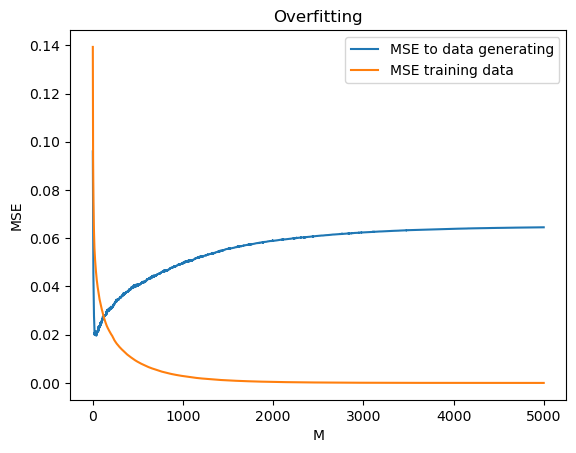

In [58]:
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_test_dg = np.sin(X_test).ravel()

reg = GradientBoostingRegressor(n_estimators=max_tree, learning_rate=LR,max_depth=1, random_state=0, loss='squared_error')
reg.fit(X,y)

test_score = np.zeros((max_tree), dtype=np.float64)
for m, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[m] = np.mean((y_pred - y_test_dg)**2)

train_score = np.zeros((max_tree), dtype=np.float64)
for m, y_pred in enumerate(reg.staged_predict(X)):
    train_score[m] = np.mean((y_pred - y)**2)

    
plt.plot(test_score, label='MSE to data generating')
plt.plot(train_score, label='MSE training data')
plt.title('Overfitting')
plt.xlabel('M')
plt.ylabel('MSE')
plt.legend()

## Minimum of the test error at
min_test = np.argmin(test_score)
print(f"Minimum of the test error at M={min_test}")

When we increase the number of estimators $M$, we see that the MSE on the training data decreases. However, the MSE on the data generating process increases. This is a clear sign of overfitting. To avoid overfitting, we could use early stopping. In praxis, we would use cross-validation or a validation set to find the optimal number of estimators.

## Introducation of a learning rate

In the learning curve from above, we saw that we reach overfitting after addting only a few trees. We now want to introduce a learning rate to avoid overfitting. The learning rate is multiplied with the prediction of each tree. 
In the code from above, we do not completly add the "delta" model but just a bit, this factor is the learning rate.

```
fx = np.zeros(num_data) #See Step 1 in Algo 10.2
for m in range(n_estimators):
    tree = DecisionTreeRegressor(max_depth=1)
    res = y - fx #Calculation of the rediduals
    tree.fit(X, res) #Fitting to the residuals (Steps 2a)
    fx = fx + LR * tree.predict(X) #<--- The new predictions (Step 2b) with LR
```

Rerun the code above and change the learning rate.

Processing learning rates: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


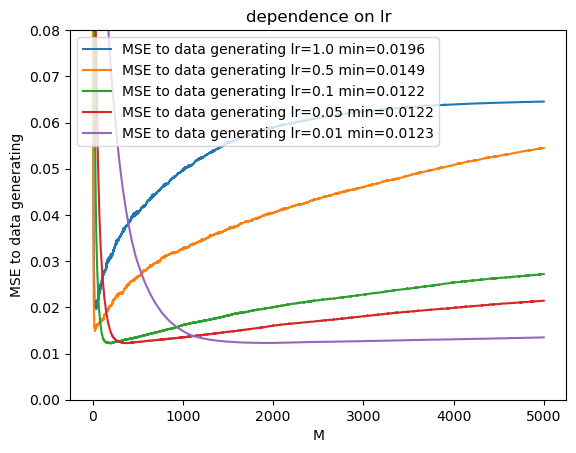

In [59]:
from tqdm import tqdm
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_test_dg = np.sin(X_test).ravel()

lr = np.asarray([1., 0.5, 0.1, 0.05, 0.01])
lr_res = np.zeros((len(lr),max_tree))

for i,lr in enumerate(tqdm(lr, desc="Processing learning rates")):
    #print(lr)
    reg = GradientBoostingRegressor(n_estimators=max_tree, learning_rate=lr,max_depth=1, random_state=0, loss='squared_error')
    reg.fit(X,y)
    test_score = np.zeros((max_tree), dtype=np.float64)
    for m, y_pred in enumerate(reg.staged_predict(X_test)):
        test_score[m] = np.mean((y_pred - y_test_dg)**2)
    plt.plot(test_score, label='MSE to data generating lr={} min={}'.format(lr,round(np.min(test_score),4)))
    #print(lr, round(np.min(test_score),6))

plt.title('dependence on lr')
plt.xlabel('M')
plt.ylabel('MSE to data generating')
plt.legend()
plt.ylim(0, 0.08)
plt.show()

#     for m, y_pred in enumerate(reg.staged_predict(X_test)):
#         lr_res[i,m] = np.mean((y_pred - y_test_dg)**2)

A lower learning rate will lead to a slower convergence. But, it will also **lead to a lower MSE** to the testdata / DGP.

## Another view on the learning rate

**The following code is just there to produce the figure for the slides in the lecture**

The learning rate resembles the stepwidth of a gradient descent. A small learning rate does only a small step towards the miminal solution. 

In [60]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
num_data = 500
X = np.linspace(0,5,num_data).reshape(num_data,1)
y = np.sin(X).ravel() + np.random.normal(0,0.05,num_data)

def plot_step(X,y,ypreds_base,ypreds):
    plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data", alpha=0.05)
    plt.plot(X, ypreds_base, color="cornflowerblue",label="M-1", linewidth=2)
    for lr in [0.1,0.5,1.0]:
        if lr < 1:
            plt.plot(X, ypreds_base + lr * delta, color="green",label="M lr={}".format(lr), linewidth=1, alpha=0.6)
        else:
            plt.plot(X, ypreds_base + lr * delta, color="green",label="M lr={}".format(lr), linewidth=2, alpha=1)
    plt.title('From M to M+1')

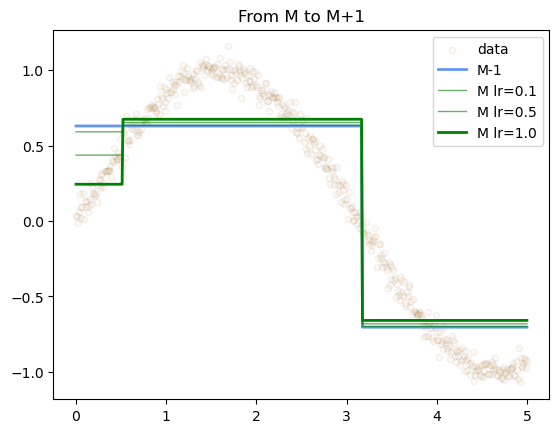

In [61]:
# Fit regression model
fx  = delta = fx_old = np.zeros(num_data) 

for m in range(2):
    tree = DecisionTreeRegressor(max_depth=1)
    res = y - fx #Calculation of the rediduals
    tree.fit(X, res) #Fitting to the residuals (Steps 2a)
    fx_old = fx
    delta = tree.predict(X)
    fx = fx + delta #The new predictions (Step 2b) with LR
    
ypreds_base = np.zeros_like(ypreds)
plot_step(X,y,fx_old,delta)
plt.legend()